In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import pi
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit.library import C3XGate, C4XGate
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from fractions import Fraction

# Question 1
## Part A

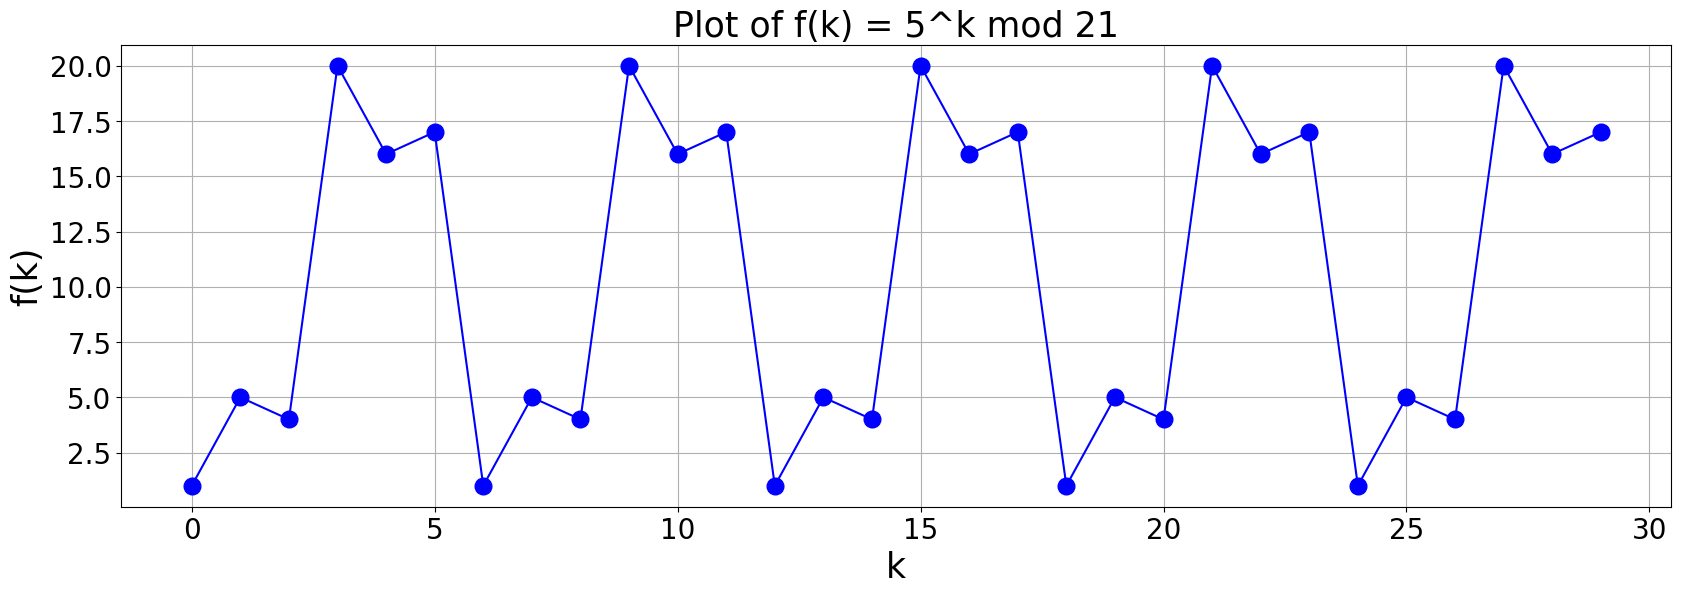

In [2]:
def f(N, x, k):
    return (x ** k) % N

N = 21
x = 5
k_values = range(30)
f_values = [f(N, x, k) for k in k_values]

plt.figure(figsize=(20, 6))
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

plt.plot(k_values, f_values, marker='o', markersize=12,linestyle='-', color='b')
plt.title(f'Plot of f(k) = {x}^k mod {N}', fontsize=25)
plt.xlabel('k', fontsize=25)
plt.ylabel('f(k)', fontsize=25)
plt.grid(True)
plt.show()

## Part E

<Figure size 640x480 with 0 Axes>

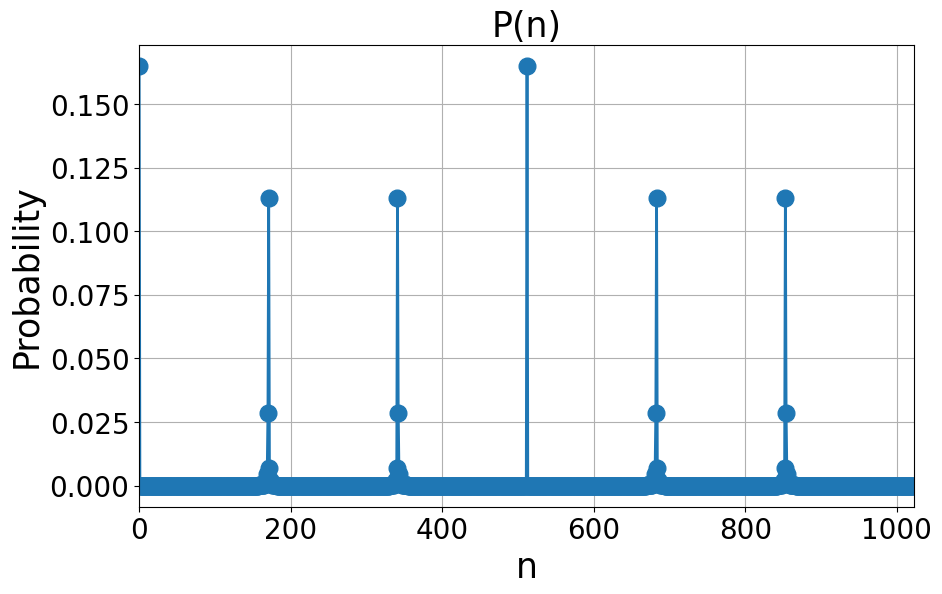

n values corresponding to results >= 0.05:
[  0 171 341 512 683 853]

Total count of matching indices: 6


In [3]:
I = 1j
m_values = np.arange(0, 170)
n_values = np.arange(0, 2**10-1)


results = np.zeros_like(n_values, dtype=float)

for idx, n in enumerate(n_values):
    exponent = np.exp(2 * pi * I * n * 6 / 1024 * m_values)
    results[idx] = (1 / (171 * 1024)) * np.abs(np.sum(exponent))**2

# Find n values where results are greater than or equal to 0.01
threshold = 0.05
matching_indices = np.where(results >= threshold)[0]


plt.figure()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=20)  # Set x-axis tick label size
plt.yticks(fontsize=20)
plt.plot(n_values, results, 'o-',markersize=12, linewidth=2)
plt.xlabel('n', fontsize=25)
plt.ylabel('Probability', fontsize=25)
plt.title('P(n)', fontsize=25)
plt.grid(True)
plt.xlim([0, 1023])
plt.show()

print(f'n values corresponding to results >= {threshold}:')
print(matching_indices)
print()

print(f'Total count of matching indices: {len(matching_indices)}')

### This code was used to find the numbers for continued fractions so it could be completed by hand. The cell is not relevant to the assignment and can be ignored.

In [4]:
def fraction_breakdown(numerator, denominator):
    values = [0,0,0]
    # Whole number
    values[0] = (int)(denominator / numerator)
    # New fraction numerator
    values[1] = denominator - numerator * values[0]
    # New fraction denominator
    values[2] = numerator

    return values

def continued_fraction(numerator, denominator):
    whole_nums = []
    vals = fraction_breakdown(numerator, denominator)
    whole_nums.append(vals[0])

    while vals[1] != 1 and vals[1] != 0:
        vals = fraction_breakdown(vals[1], vals[2])
        whole_nums.append(vals[0])

    if vals[1] != 0:
        whole_nums.append((int)(vals[2])) # The last denominator is the last whole number
    return whole_nums     

# Test
for number in matching_indices[1:]:
    nums = continued_fraction(number, 1024)
    print(nums)

[5, 1, 84, 2]
[3, 341]
[2]
[1, 2, 341]
[1, 4, 1, 84, 2]


# Question 2
## Part B
### The circuit is hard to read because barriers had to be removed for to_gate() to work.
### Bit 1 is used as ancilla for all three parts, being reset at the end of each part.
### Bit 3 is used as ancilla after part 1 so that an input 4 can be distinguished from input 5 becoming 4.

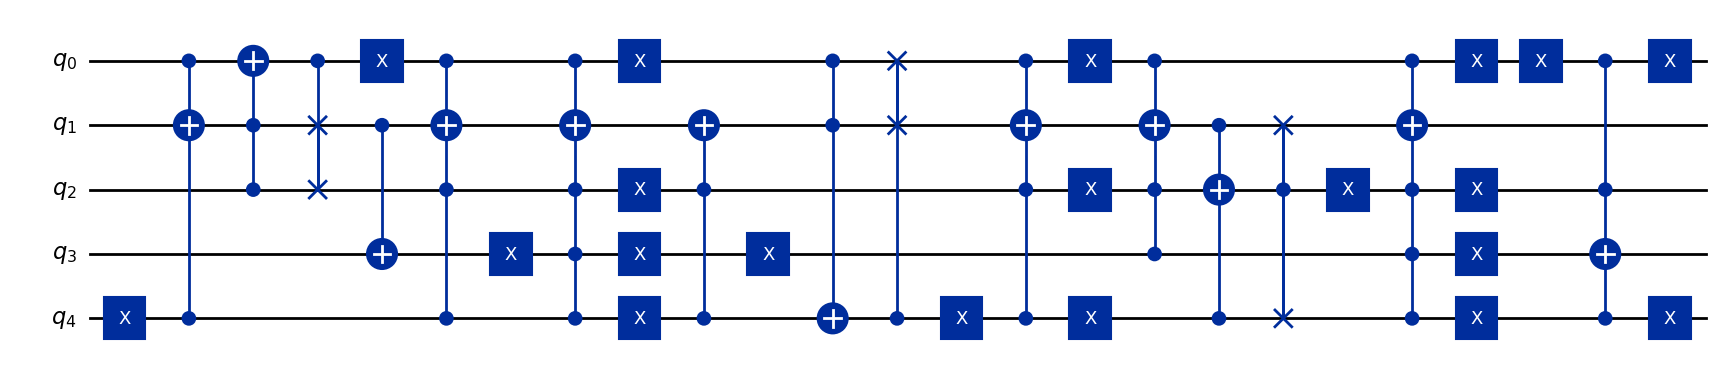

In [5]:
def mod_5y_21():
    qc = QuantumCircuit(5)
    
    # Part 1: y = 1 or y = 5 (Focus on bit 0)
    qc.x(4)
    qc.ccx(0, 4, 1)
    qc.ccx(1, 2, 0)
    qc.cswap(0, 1, 2)
    qc.cx(1, 3) # Store that 4 was made and not the initial state
    qc.x(0)
    qc.append(C3XGate(), [0, 2, 4, 1])
    qc.x(3)
    qc.append(C4XGate(), [0, 2, 4, 3, 1])
    qc.x(0)
    qc.x(4)
    qc.x(3)
    
    # Part 2: y = 16 or y = 17 (Focus on bit 4)
    qc.x(2)
    qc.ccx(4, 2, 1)
    qc.ccx(1, 0, 4)
    qc.cswap(4, 1, 0)
    qc.x(4)
    qc.append(C3XGate(), [4, 0, 2, 1])
    qc.x(4)
    qc.x(2)
    
    # Part 3: y = 4 or y = 20 (Focus on bit 2)
    qc.x(0)
    qc.x(3)
    qc.append(C3XGate(), [2, 0, 3, 1])
    qc.ccx(1, 4, 2)
    qc.cswap(2, 1, 4)
    qc.x(2)
    qc.append(C4XGate(), [2, 4, 0, 3, 1])
    qc.x(3)
    qc.x(2)
    qc.x(0) # This causes an x-x that should be removed, but is left in place to show how the bits are used in each part
    
    # Reset bit 3
    qc.x(0)
    qc.x(4)
    qc.append(C3XGate(), [0, 2, 4, 3])
    qc.x(0)
    qc.x(4)

    return qc

qc = mod_5y_21()
qc.draw('mpl')

{'00101 00000': 1024}
{'00100 00000': 1024}
{'10100 00000': 1024}
{'10000 00000': 1024}
{'10001 00000': 1024}
{'00001 00000': 1024}


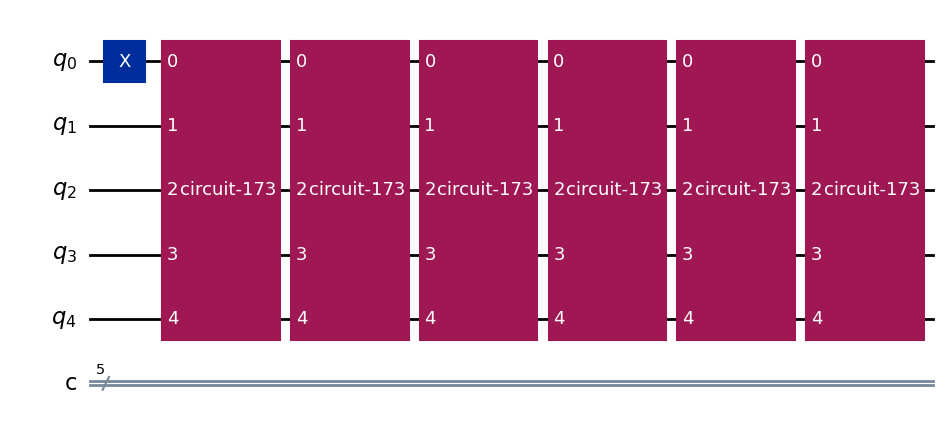

In [6]:
# Test the previous circuit to see that it cycles the proper values
qc = QuantumCircuit(5, 5)
qc.x(0)
simulator = AerSimulator()

mod = mod_5y_21()
for i in range(6):
    qc.append(mod, [0,1,2,3,4])
    # Copy the circuit to measure the bits after each iteration
    qc2 = qc.copy()
    qc2.measure_all()
    compiled_circuit = transpile(qc2, simulator)
    counts = simulator.run(compiled_circuit).result().get_counts()
    print(counts)
    
qc.draw('mpl')

## Part C

In [7]:
def mod_5y_21_2even():
    qc = QuantumCircuit(5)
    qc.swap(0, 4)
    qc.swap(0, 2)
    return qc

def mod_5y_21_2odd():
    qc = QuantumCircuit(5)
    qc.swap(0, 2)
    qc.swap(0, 4)
    return qc

def mod_5y_21_2pow_control(power):
    qc = QuantumCircuit(5, name="5^n mod21")
    if power == 0:
        qc = mod_5y_21()
    elif power % 2 == 0:
        qc = mod_5y_21_2even()
    else:
        qc = mod_5y_21_2odd()

    return qc.to_gate().control(1)

{'10000 00000': 1024}
{'00100 00000': 1024}
{'00001 00000': 1024}


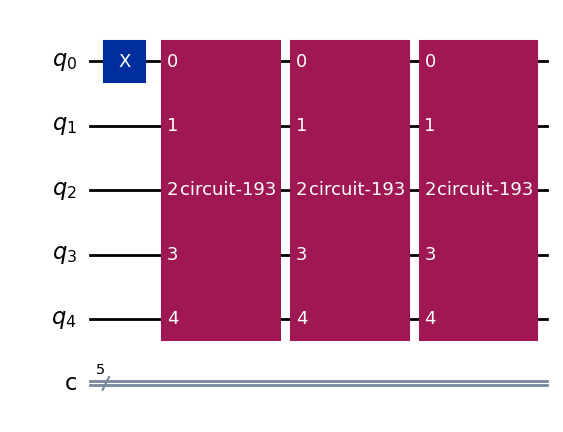

In [8]:
qc = QuantumCircuit(5, 5)
qc.x(0) # Change the input to see that it works for any input
simulator = AerSimulator()

mod_even = mod_5y_21_2even()
for i in range(3):
    qc.append(mod_even, [0,1,2,3,4])
    # Copy the circuit to measure the bits after each iteration
    qc2 = qc.copy()
    qc2.measure_all()
    compiled_circuit = transpile(qc2, simulator)
    counts = simulator.run(compiled_circuit).result().get_counts()
    print(counts)
    
qc.draw('mpl')

{'00100 00000': 1024}
{'10000 00000': 1024}
{'00001 00000': 1024}


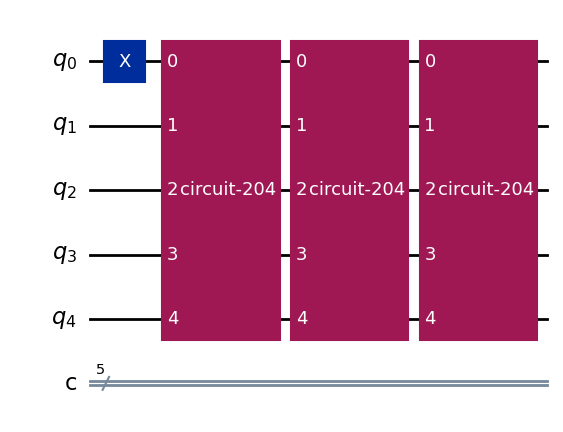

In [9]:
qc = QuantumCircuit(5, 5)
qc.x(0) # Change the input to see that it works for any input
simulator = AerSimulator()

mod_odd = mod_5y_21_2odd()
for i in range(3):
    qc.append(mod_odd, [0,1,2,3,4])
    # Copy the circuit to measure the bits after each iteration
    qc2 = qc.copy()
    qc2.measure_all()
    compiled_circuit = transpile(qc2, simulator)
    counts = simulator.run(compiled_circuit).result().get_counts()
    print(counts)
    
qc.draw('mpl')

## Part D
### Most of this code was taken from "QuaC 605 shor circuit.ipynb" and modified to work with the previous code

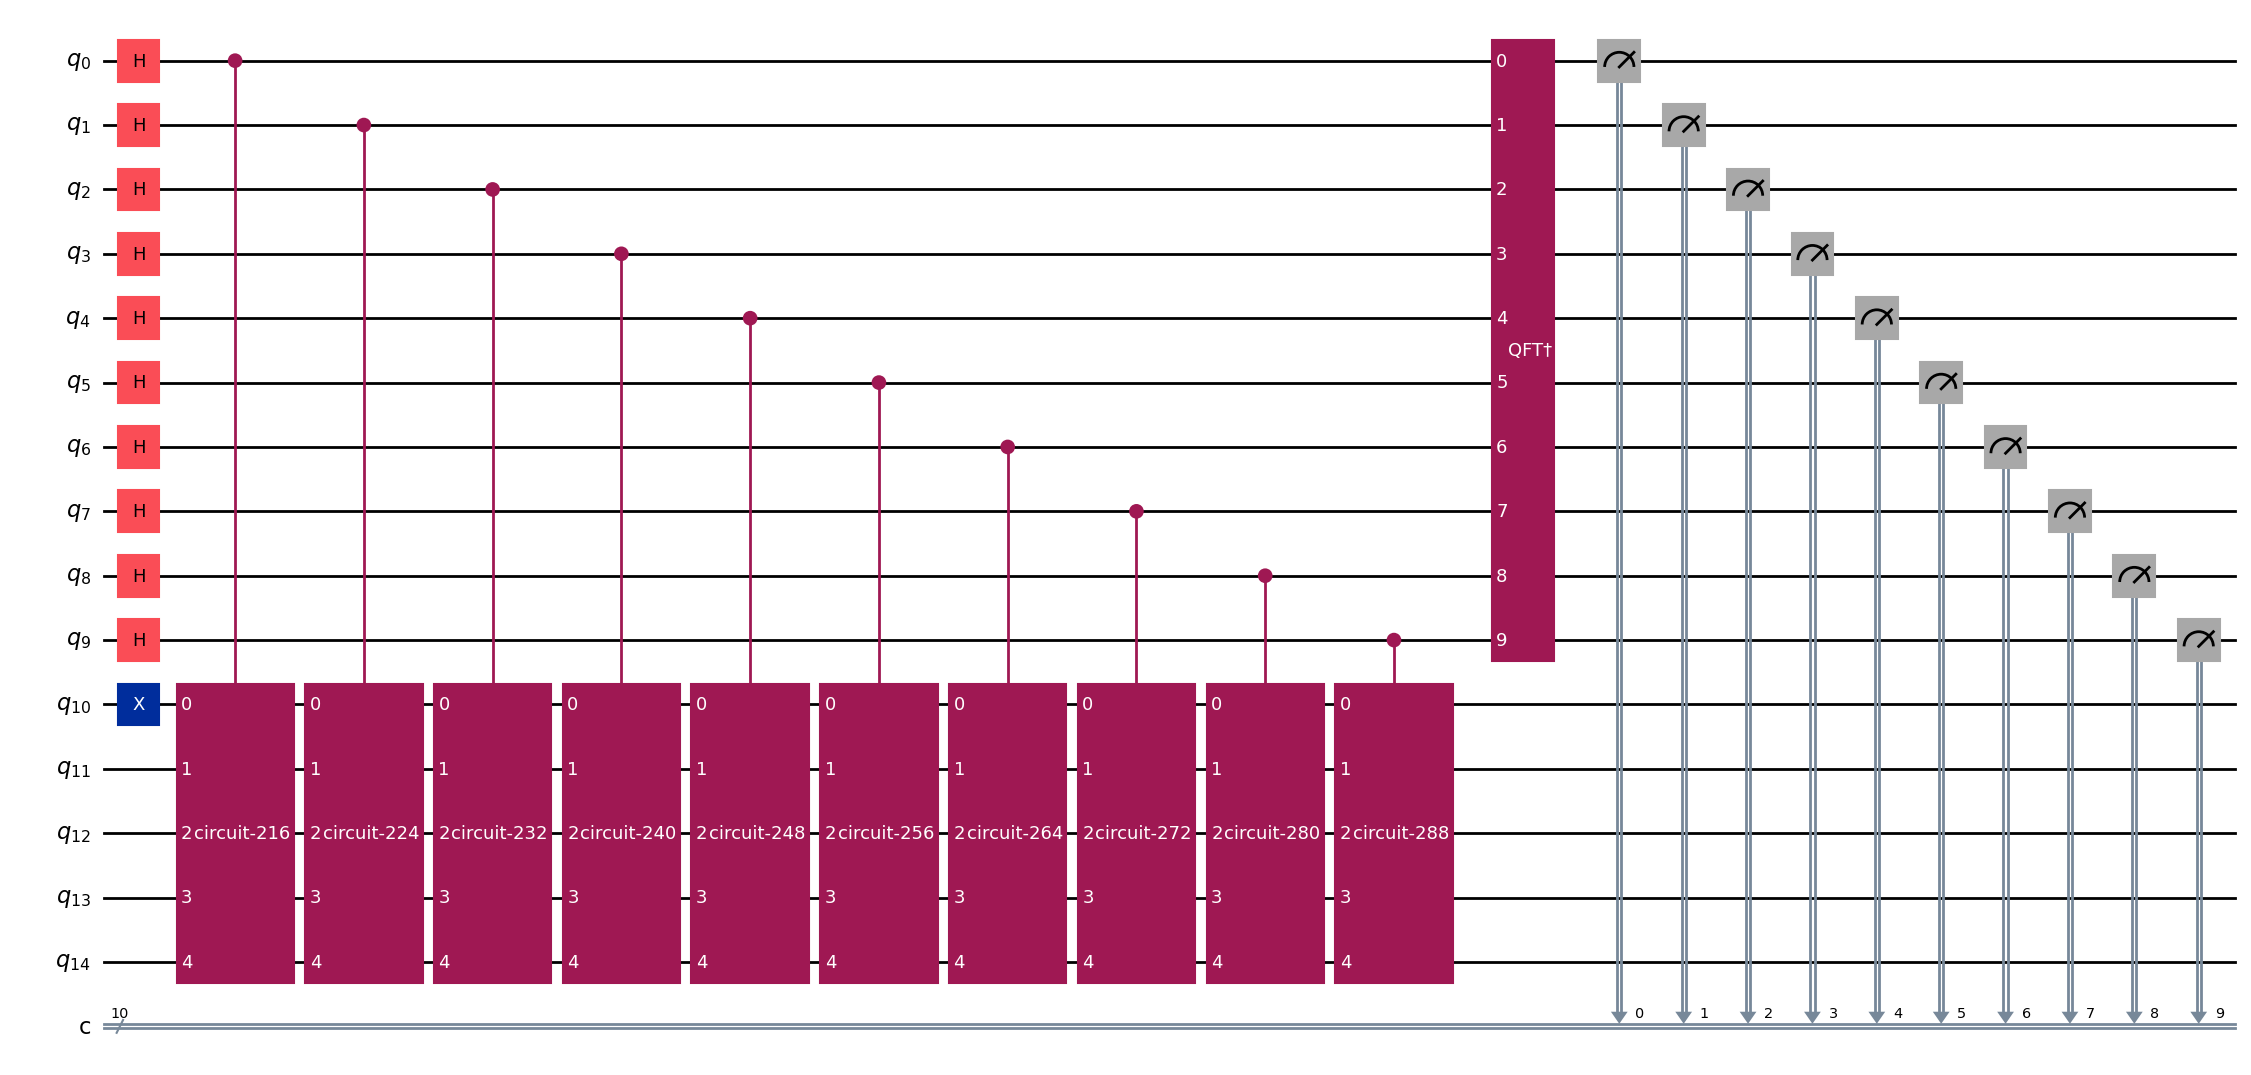

In [10]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc
    
#10 counting qubits
N_COUNT = 10

# Create QuantumCircuit with N_COUNT counting qubits
# plus 5 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 5, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(mod_5y_21_2pow_control(q),
             [q] + [i+N_COUNT for i in range(5)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw('mpl',fold=-1)  # -1 means 'do not fold'

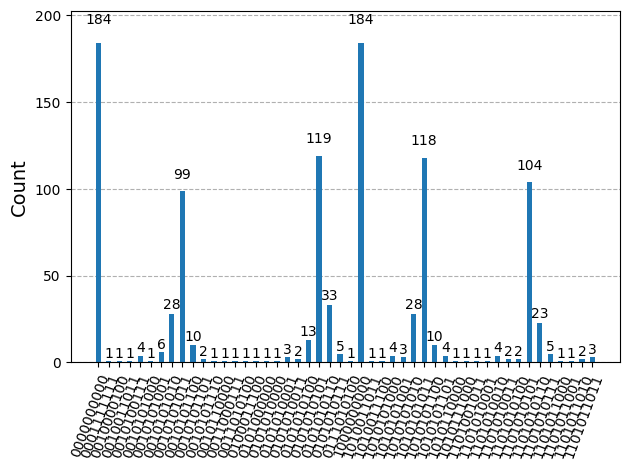

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [12]:
outputs = counts.int_outcomes()
measured_phases = []
for output, count in outputs.items():
    if count > 50: # Only grab peak values
        phase = output/(2**N_COUNT)  # Find corresponding eigenvalue
        measured_phases.append(phase)

measured_phases.sort()
print(measured_phases)

[0.0, 0.1669921875, 0.3330078125, 0.5, 0.6669921875, 0.8330078125]


In [13]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0  0.000000      0/1            1
1  0.166992      1/6            6
2  0.333008      1/3            3
3  0.500000      1/2            2
4  0.666992      2/3            3
5  0.833008      5/6            6


### From the fractions, and the guesses for r, we can see that the true value of r must be 6.

# Question 3
## Part B

In [14]:
def mod_2y_21():
    qc = QuantumCircuit(5)
    qc.swap(0, 1)
    qc.swap(0, 2)
    
    qc.swap(0, 3)
    qc.swap(0, 4)
    
    qc.x(4)
    qc.ccx(0, 4, 1)
    qc.ccx(0, 1, 3)
    qc.x(4)
    
    qc.x(3)
    qc.append(C4XGate(), [4, 3, 2, 1, 0])
    qc.append(C3XGate(), [2, 0, 1, 4])
    qc.x(4)
    qc.append(C3XGate(), [3, 0, 4, 2])
    qc.append(C3XGate(), [3, 0, 4, 1])
    qc.x(4)
    qc.x(3)

    return qc

{'00010 00000': 1024}
{'00100 00000': 1024}
{'01000 00000': 1024}
{'10000 00000': 1024}
{'01011 00000': 1024}
{'00001 00000': 1024}


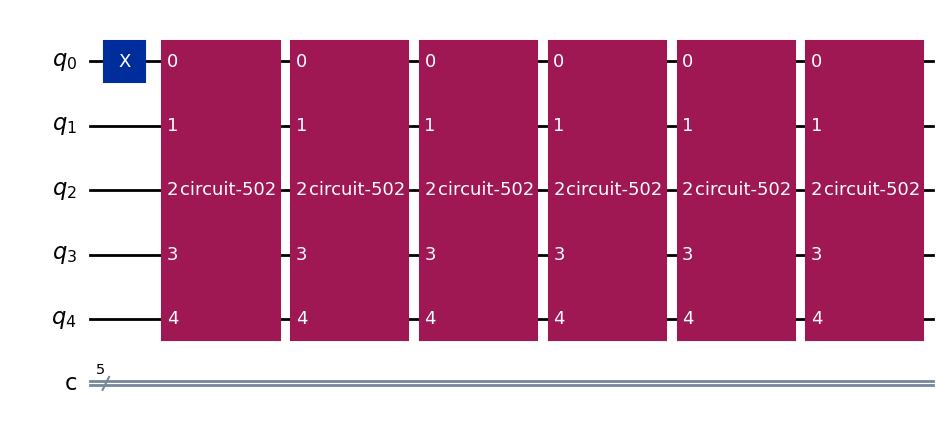

In [15]:
qc = QuantumCircuit(5, 5)
qc.x(0)
simulator = AerSimulator()

mod = mod_2y_21()
for i in range(6):
    qc.append(mod, [0,1,2,3,4])
    # Copy the circuit to measure the bits after each iteration
    qc2 = qc.copy()
    qc2.measure_all()
    compiled_circuit = transpile(qc2, simulator)
    counts = simulator.run(compiled_circuit).result().get_counts()
    print(counts)
    
qc.draw('mpl')

### In the printed strings above, the first 5 bits of each string correspond to the qubits, the second 5 are the C-bits.
### Each line is a measurement of the state after the circuit is performed once.
### Clearly, the circuit iterates through 1-2-4-8-16-11-1, following the outputs from Table 2.

## Part D

In [16]:
def mod_2y_21_2even():
    qc = QuantumCircuit(5)

    # Cycle 0, 2, and 4 bits
    qc.swap(0, 4)
    qc.swap(0, 2)
    # Swap 1 and 3 bits
    qc.swap(1, 3)

    # Turn 01011 into 01101 so normal circuit can apply
    qc.ccx(1, 4, 3)
    qc.ccx(1, 4, 2)

    # This is the same as the general circuit
    qc.x(4)
    qc.ccx(3, 4, 0)
    qc.ccx(0, 3, 1)
    qc.x(4)

    # This is the general circuit but designed to turn 11 into 8, rather than into 1
    qc.x(0)
    qc.append(C4XGate(), [4, 2, 1, 0, 3])
    qc.append(C3XGate(), [2, 0, 1, 4])
    qc.x(4)
    qc.append(C3XGate(), [3, 0, 4, 2])
    qc.append(C3XGate(), [3, 0, 4, 1])
    qc.x(4)
    qc.x(0)

    return qc

def mod_2y_21_2odd():
    qc = QuantumCircuit(5)

    # Cycle 0, 2, and 4 bits
    qc.swap(0, 2)
    qc.swap(0, 4)
    # Swap 1 and 3 bits
    qc.swap(1, 3)

    # Turn 01110 into 01101 so normal circuit can apply
    qc.ccx(1, 2, 3)
    qc.ccx(1, 2, 4)

    # This is the same as the general circuit
    qc.x(4)
    qc.ccx(1, 4, 0)
    qc.ccx(0, 1, 3)
    qc.x(4)

    # This is the general circuit but designed to turn 11 into 8, rather than into 1
    qc.x(0)
    qc.append(C4XGate(), [4, 2, 1, 0, 3])
    qc.append(C3XGate(), [2, 0, 1, 4])
    qc.x(4)
    qc.append(C3XGate(), [1, 0, 4, 2])
    qc.append(C3XGate(), [1, 0, 4, 3])
    qc.x(4)
    qc.x(0)

    return qc

def mod_2y_21_2pow_control(power):
    qc = QuantumCircuit(5, name="5^n mod21")
    if power == 0:
        qc = mod_2y_21()
    elif power % 2 == 0:
        qc = mod_2y_21_2even()
    else:
        qc = mod_2y_21_2odd()

    return qc.to_gate().control(1)

{'01011 00000': 1024}
{'01000 00000': 1024}
{'00010 00000': 1024}


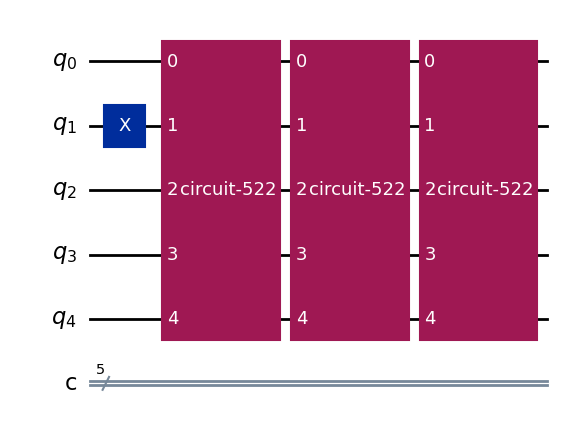

In [17]:
qc = QuantumCircuit(5, 5)
qc.x(1) # Change the input to see that it works for any input
simulator = AerSimulator()

mod_even = mod_2y_21_2even()
for i in range(3):
    qc.append(mod_even, [0,1,2,3,4])
    # Copy the circuit to measure the bits after each iteration
    qc2 = qc.copy()
    qc2.measure_all()
    compiled_circuit = transpile(qc2, simulator)
    counts = simulator.run(compiled_circuit).result().get_counts()
    print(counts)
    
qc.draw('mpl')

{'01000 00000': 1024}
{'01011 00000': 1024}
{'00010 00000': 1024}


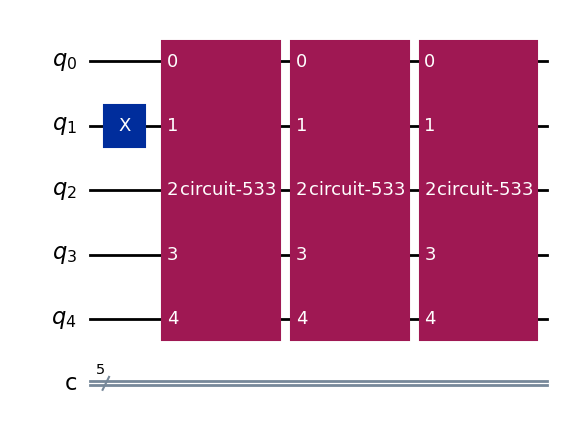

In [18]:
qc = QuantumCircuit(5, 5)
qc.x(1) # Change the input to see that it works for any input
simulator = AerSimulator()

mod_odd = mod_2y_21_2odd()
for i in range(3):
    qc.append(mod_odd, [0,1,2,3,4])
    # Copy the circuit to measure the bits after each iteration
    qc2 = qc.copy()
    qc2.measure_all()
    compiled_circuit = transpile(qc2, simulator)
    counts = simulator.run(compiled_circuit).result().get_counts()
    print(counts)
    
qc.draw('mpl')

## Part E
### As like before, most of this code was taken and modified by code provided in class.

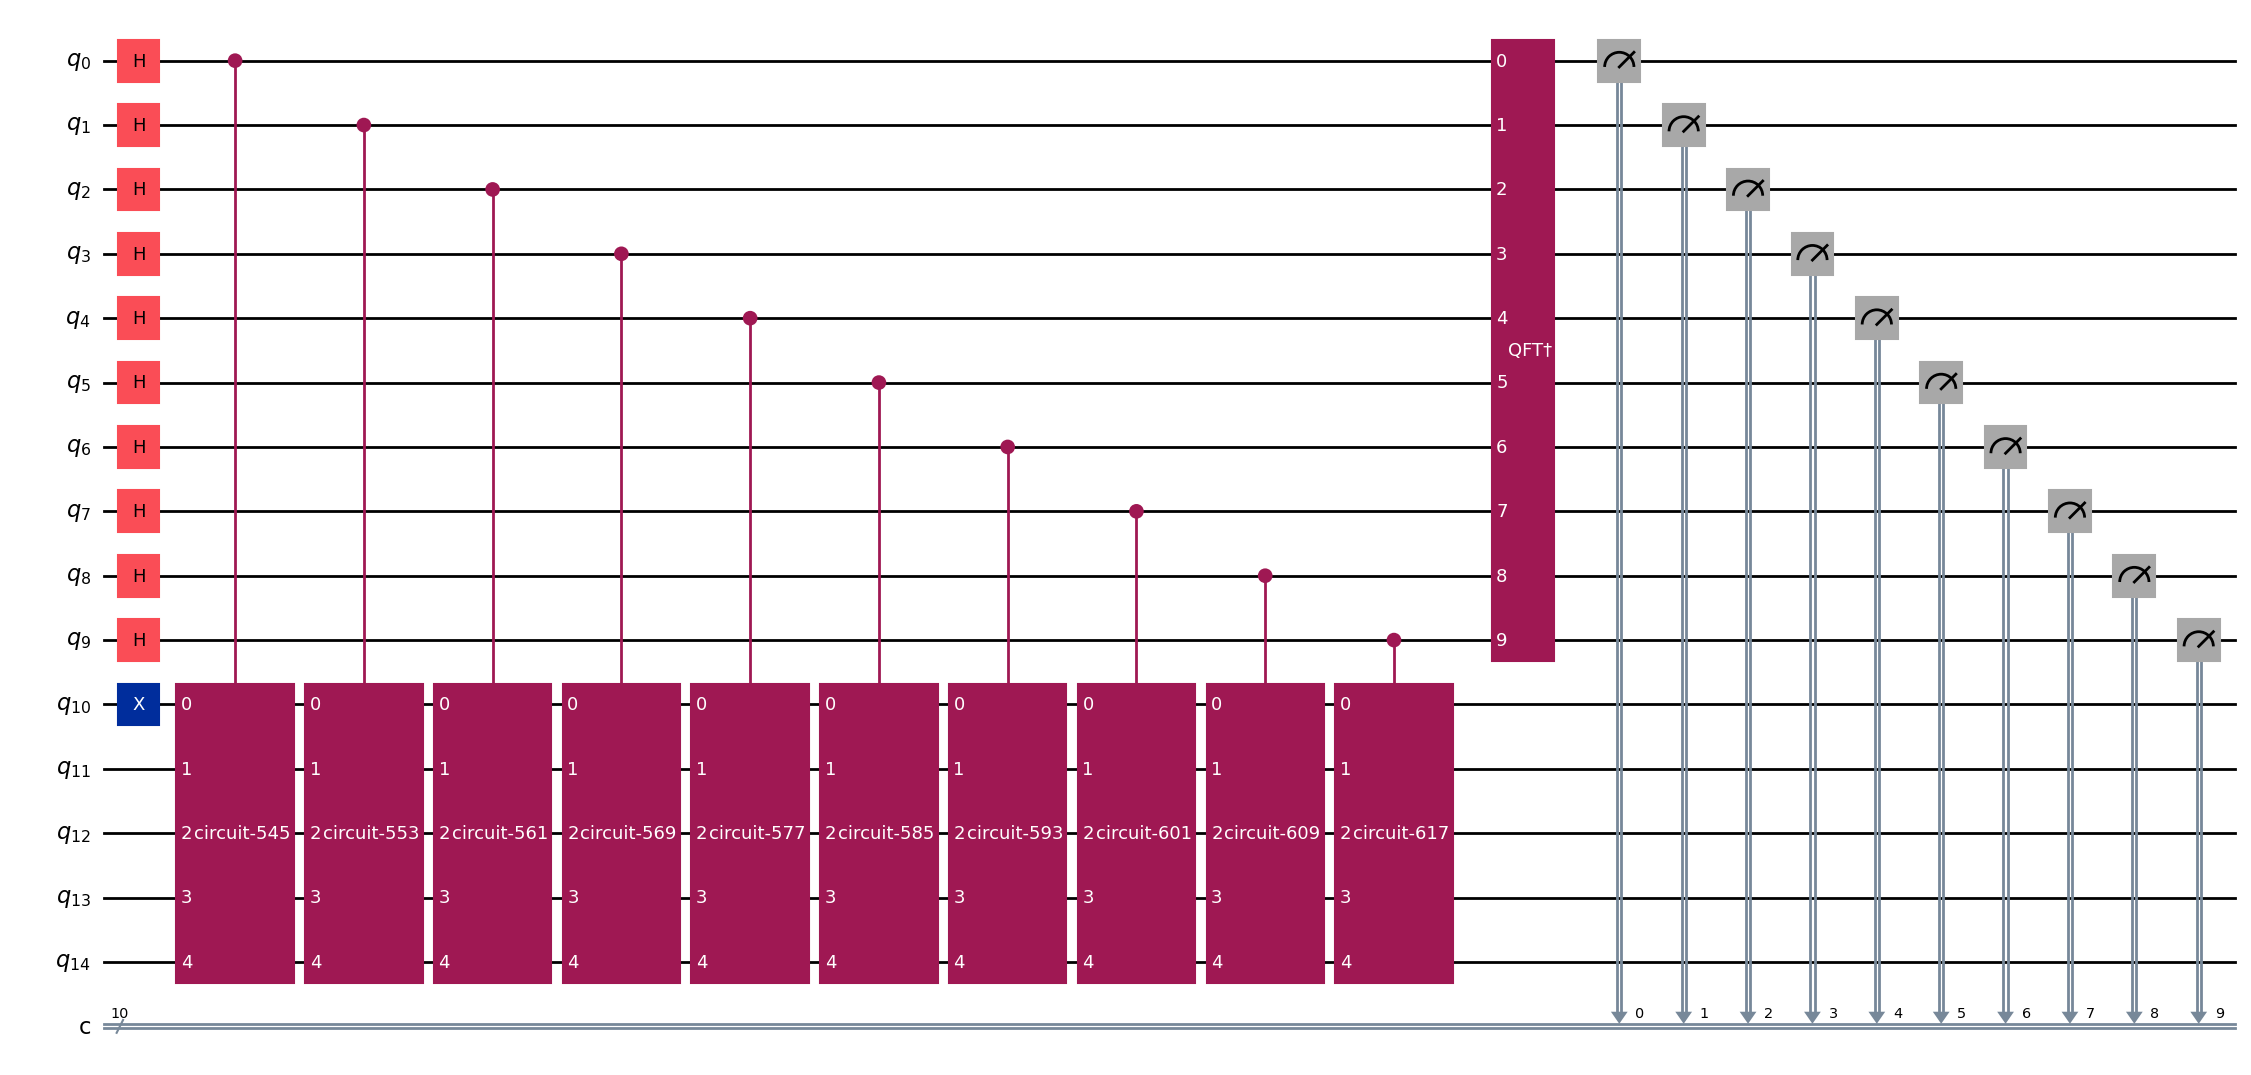

In [19]:
#10 counting qubits
N_COUNT = 10

# Create QuantumCircuit with N_COUNT counting qubits
# plus 5 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 5, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(mod_2y_21_2pow_control(q),
             [q] + [i+N_COUNT for i in range(5)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw('mpl',fold=-1)  # -1 means 'do not fold'

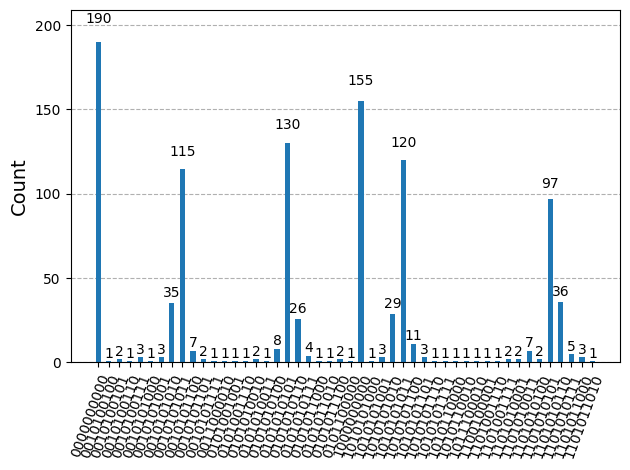

In [20]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [21]:
outputs = counts.int_outcomes()
measured_phases = []
for output, count in outputs.items():
    if count > 40: # Only grab peak values
        phase = output/(2**N_COUNT)  # Find corresponding eigenvalue
        measured_phases.append(phase)

measured_phases.sort()
print(measured_phases)

[0.0, 0.1669921875, 0.3330078125, 0.5, 0.6669921875, 0.8330078125]


In [22]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0  0.000000      0/1            1
1  0.166992      1/6            6
2  0.333008      1/3            3
3  0.500000      1/2            2
4  0.666992      2/3            3
5  0.833008      5/6            6


### From the fractions, and the guesses for r, we can see that the true value of r must be 6.